### installations and imports

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
import praw
import torch

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification

### fetch bitcoin data and reddit news

In [18]:
crypto_currency = 'BTC-USD'

start = dt.datetime.now() - dt.timedelta(days=730)
end = dt.datetime.now()

try:
    # Retrieve cryptocurrency data with hourly interval
    data = yf.download(crypto_currency, start=start, end=end, interval='60m')
    
    print(data)
except Exception as e:
    print(f"Error retrieving data: {e}")

[*********************100%%**********************]  1 of 1 completed

                             Open          High           Low         Close  \
Datetime                                                                      
2022-08-13 13:00:00  24456.318359  24514.707031  24440.279297  24454.464844   
2022-08-13 14:00:00  24460.687500  24514.396484  24459.511719  24476.464844   
2022-08-13 15:00:00  24474.068359  24565.957031  24470.765625  24534.761719   
2022-08-13 16:00:00  24534.474609  24550.628906  24483.380859  24483.380859   
2022-08-13 17:00:00  24483.654297  24569.919922  24483.654297  24568.273438   
...                           ...           ...           ...           ...   
2024-08-12 07:00:00  58425.742188  58917.292969  57712.968750  58679.566406   
2024-08-12 08:00:00  58688.007812  58969.140625  58400.820312  58400.820312   
2024-08-12 09:00:00  58370.515625  58594.039062  58211.300781  58338.054688   
2024-08-12 10:00:00  58317.496094  59003.066406  58189.003906  59003.066406   
2024-08-12 11:00:00  59048.195312  59806.035156  590

In [29]:
# Reddit API credentials
client_id = '-DikpAFUeeajlFFyWTBqUg'
client_secret = 'yZu1rPuBINVPuI7LuugQybGwtX1Cdg'
user_agent = 'bitcoin data'
username = '73malik'
password = 'Stapler437581-'

# Initialize the Reddit API
reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                      user_agent=user_agent)

# Define batch size (number of hours per batch)
batch_size = 24 * 7 # Fetch posts for x hours at a time

# Generate sentiment data corresponding to each hour in your dataset
sentiment_data = []
# Loop through your data in batches of `batch_size`
for i in range(0, len(data), batch_size):
    batch_start = data.index[i]
    batch_end = data.index[min(i + batch_size - 1, len(data) - 1)]

    # Fetch posts (without after and before parameters)
    submissions = reddit.subreddit('cryptocurrency').search('bitcoin')

    # Initialize a dictionary to store sentiment scores by hour
    hourly_sentiments = {hour: [] for hour in pd.date_range(start=batch_start, end=batch_end, freq='h')}

    # Process each submission
    for submission in submissions:
        post_time = dt.datetime.fromtimestamp(submission.created_utc)
        
        # Filter posts that fall within the batch_start and batch_end times
        if batch_start <= post_time <= batch_end:
            sentiment = TextBlob(submission.title).sentiment.polarity
            
            # Round down post time to the nearest hour
            post_hour = post_time.replace(minute=0, second=0, microsecond=0)
            
            # Add sentiment to the corresponding hour
            if post_hour in hourly_sentiments:
                hourly_sentiments[post_hour].append(sentiment)
    
    # Calculate average sentiment for each hour in the batch
    for hour, sentiments in hourly_sentiments.items():
        avg_sentiment = np.mean(sentiments) if sentiments else 0  # Neutral if no posts
        sentiment_data.append(avg_sentiment)
    
    print(f"Processed batch {i//batch_size + 1}/{len(data)//batch_size + 1}")


C:\Users\malik\AppData\Local\Temp\ipykernel_1264\3624019232.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_sentiments = {hour: [] for hour in pd.date_range(start=batch_start, end=batch_end, freq='H')}


Processed batch 1/104
Processed batch 2/104
Processed batch 3/104
Processed batch 4/104
Processed batch 5/104
Processed batch 6/104
Processed batch 7/104
Processed batch 8/104
Processed batch 9/104
Processed batch 10/104
Processed batch 11/104
Processed batch 12/104
Processed batch 13/104
Processed batch 14/104
Processed batch 15/104
Processed batch 16/104
Processed batch 17/104
Processed batch 18/104
Processed batch 19/104
Processed batch 20/104
Processed batch 21/104
Processed batch 22/104
Processed batch 23/104
Processed batch 24/104
Processed batch 25/104
Processed batch 26/104
Processed batch 27/104
Processed batch 28/104
Processed batch 29/104
Processed batch 30/104
Processed batch 31/104
Processed batch 32/104
Processed batch 33/104
Processed batch 34/104
Processed batch 35/104
Processed batch 36/104
Processed batch 37/104
Processed batch 38/104
Processed batch 39/104
Processed batch 40/104
Processed batch 41/104
Processed batch 42/104
Processed batch 43/104
Processed batch 44/1

ValueError: Length of values (17519) does not match length of index (17435)

In [30]:

print(f"Length of sentiment_data: {len(sentiment_data)}")
print(f"Length of data.index: {len(data.index)}")

# Ensure the length of sentiment_data matches data.index
if len(sentiment_data) != len(data.index):
    print(f"Length mismatch: sentiment_data ({len(sentiment_data)}) vs data.index ({len(data.index)})")
    # Trimming or extending sentiment_data as necessary
    if len(sentiment_data) > len(data.index):
        sentiment_data = sentiment_data[:len(data.index)]
    else:
        # If shorter, you might need to pad sentiment_data with neutral scores (0)
        sentiment_data.extend([0] * (len(data.index) - len(sentiment_data)))

# Convert sentiment data into a pandas Series and add to your DataFrame
data['Sentiment'] = pd.Series(sentiment_data, index=data.index[:len(sentiment_data)])

Length of sentiment_data: 17519
Length of data.index: 17435
Length mismatch: sentiment_data (17519) vs data.index (17435)


In [31]:
print(sentiment_data)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [32]:
print(data)

                             Open          High           Low         Close  \
Datetime                                                                      
2022-08-13 13:00:00  24456.318359  24514.707031  24440.279297  24454.464844   
2022-08-13 14:00:00  24460.687500  24514.396484  24459.511719  24476.464844   
2022-08-13 15:00:00  24474.068359  24565.957031  24470.765625  24534.761719   
2022-08-13 16:00:00  24534.474609  24550.628906  24483.380859  24483.380859   
2022-08-13 17:00:00  24483.654297  24569.919922  24483.654297  24568.273438   
...                           ...           ...           ...           ...   
2024-08-12 07:00:00  58425.742188  58917.292969  57712.968750  58679.566406   
2024-08-12 08:00:00  58688.007812  58969.140625  58400.820312  58400.820312   
2024-08-12 09:00:00  58370.515625  58594.039062  58211.300781  58338.054688   
2024-08-12 10:00:00  58317.496094  59003.066406  58189.003906  59003.066406   
2024-08-12 11:00:00  59048.195312  59806.035156  590

### prepare data

In [3]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the data
scaled_data = scaler.fit_transform(data['Close', 'Sentiment'].values.reshape(-1, 1))

# Define prediction hours (e.g., using the past 60 hours to predict the next hour)
prediction_hours = 60

# Prepare the training data
x_train, y_train = [], []

for x in range(prediction_hours, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_hours:x, 0])
    y_train.append(scaled_data[x, 0])

# Convert the lists to NumPy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the input data to the required shape for the model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))

# Print the shapes to verify
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')

x_train shape: (17375, 60, 1)
y_train shape: (17375,)


### create neural network

In [4]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))


model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
543/543 [==============================] - 22s 25ms/step - loss: 0.0038
Epoch 2/25
543/543 [==============================] - 14s 25ms/step - loss: 0.0015
Epoch 3/25
543/543 [==============================] - 14s 25ms/step - loss: 0.0012
Epoch 4/25
543/543 [==============================] - 13s 24ms/step - loss: 0.0011
Epoch 5/25
543/543 [==============================] - 13s 25ms/step - loss: 9.1321e-04
Epoch 6/25
543/543 [==============================] - 15s 28ms/step - loss: 9.3477e-04
Epoch 7/25
543/543 [==============================] - 14s 25ms/step - loss: 8.1729e-04
Epoch 8/25
543/543 [==============================] - 14s 27ms/step - loss: 8.5924e-04
Epoch 9/25
543/543 [==============================] - 14s 26ms/step - loss: 8.0193e-04
Epoch 10/25
543/543 [==============================] - 14s 25ms/step - loss: 7.2726e-04
Epoch 11/25
543/543 [==============================] - 14s 25ms/step - loss: 7.5689e-04
Epoch 12/25
543/543 [==============================] - 14

### testing the data

In [5]:
# Define the cryptocurrency and against currency
crypto_currency = 'BTC-USD'

# Define the date range for testing
start = dt.datetime.now() - dt.timedelta(days=60)
test_end = dt.datetime.now()

# Retrieve test data with hourly intervals
test_data = yf.download(crypto_currency, start=start, end=test_end, interval='60m')

# Get the actual prices
actual_prices = test_data['Close'].values

# Assuming `data` contains your training data
# Combine the training data with the test data
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

# Prepare model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_hours:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# Prepare the test data for predictions
x_test = []

for x in range(prediction_hours, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_hours:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Print the predicted prices
print(predicted_prices)

[*********************100%%**********************]  1 of 1 completed


45/45 [==============================] - 1s 9ms/step
[[59601.504]
 [60419.816]
 [61708.883]
 ...
 [59561.234]
 [59512.86 ]
 [59516.78 ]]


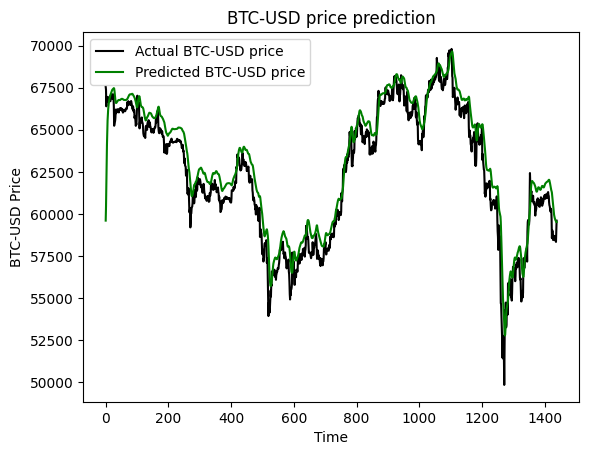

In [6]:
plt.plot(actual_prices, color='black', label=f'Actual {crypto_currency} price')
plt.plot(predicted_prices, color='green', label=f'Predicted {crypto_currency} price')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel(f'{crypto_currency} Price')
plt.legend(loc='upper left')
plt.show()

### predict next day

In [10]:
# Number of hours to predict (10 days * 24 hours)
num_hours_to_predict = 24

# Initialize the input data with the 240 hours prior to the last 240 hours of the actual data
start_index = len(model_inputs) - prediction_hours - num_hours_to_predict
real_data = model_inputs[start_index:start_index + prediction_hours, 0]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (1, real_data.shape[0], 1))

predicted_prices = []

for _ in range(num_hours_to_predict):
    # Predict the next hour's price
    predicted = model.predict(real_data)
    predicted_price = scaler.inverse_transform(predicted)[0][0]
    predicted_prices.append(predicted_price)
    
    # Update the input data with the new prediction
    new_input = np.append(real_data[0][1:], [[predicted[0][0]]], axis=0)
    real_data = np.reshape(new_input, (1, new_input.shape[0], 1))

# Extract the actual prices for the last 240 hours for comparison
actual_prices = scaler.inverse_transform(model_inputs[-num_hours_to_predict:].reshape(-1, 1)).flatten()

# Print the predicted prices for the next 240 hours
print(f'Predicted prices for the next {num_hours_to_predict} hours: {predicted_prices}')

# Print the actual prices for the last 240 hours
print(f'Actual prices for the last {num_hours_to_predict} hours: {actual_prices}')


1/1 [==============================] - 0s 23ms/step
Predicted prices for the next 24 hours: [61991.0, 62029.04, 62139.496, 62289.555, 62454.785, 62621.797, 62785.137, 62943.633, 63097.9, 63248.945, 63397.68, 63544.656, 63690.137, 63834.234, 63976.87, 64117.984, 64257.453, 64395.18, 64531.094, 64665.13, 64797.242, 64927.402, 65055.598, 65181.8]
Actual prices for the last 24 hours: [60520.04296875 60462.58203125 60340.88671875 60147.92578125
 60209.30078125 60308.44140625 60255.54296875 59694.50390625
 58559.125      58986.0390625  59014.30078125 58757.7734375
 58444.83203125 58647.5859375  58702.6484375  58522.515625
 58536.29296875 58572.58203125 58442.4921875  58679.56640625
 58400.8203125  58338.0546875  59003.06640625 59599.28125   ]


In [11]:
# Calculate and print the mean squared error
mse = mean_squared_error(actual_prices, predicted_prices)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 21912275.742949795


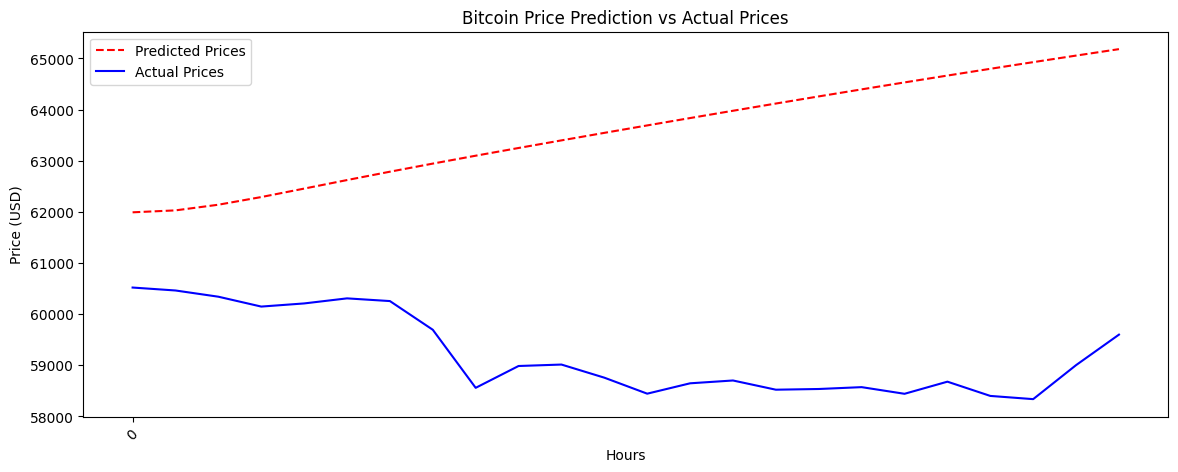

In [12]:
# Optionally, plot the predicted and actual prices for comparison
plt.figure(figsize=(14, 5))
plt.plot(range(num_hours_to_predict), predicted_prices, color='red', linestyle='dashed', label='Predicted Prices')
plt.plot(range(num_hours_to_predict), actual_prices, color='blue', linestyle='solid', label='Actual Prices')
plt.title('Bitcoin Price Prediction vs Actual Prices')
plt.xlabel('Hours')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(range(0, num_hours_to_predict, 24), rotation=45)  # Label every 24 hours
plt.show()